In [146]:
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smf
from sklearn.model_selection import train_test_split 
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import random

#### 1.Write code to estimate the treatment effects if a ‘different room is assigned’ as the treatment indicator and interpret its effect on the room being ‘canceled’. Use all the other columns as the covariates. Write your observations for the results. <br>

In [147]:
hotel = pd.read_csv('hotel_cancellation.csv') #Read Data

In [148]:
hotel.head() 

,Unnamed: 0,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,days_in_waiting_list,different_room_assigned,is_canceled
0,3,13,2015,27,1,0,False,False
1,4,14,2015,27,1,0,False,False
2,5,14,2015,27,1,0,False,False
3,7,9,2015,27,1,0,False,False
4,8,85,2015,27,1,0,False,True


In [149]:
#Create a binary indicator for treatment, different room assigned = FALSE is 0 and = TRUE is 1
hotel.loc[hotel['different_room_assigned'] == False, 'treatment'] = 0
hotel.loc[hotel['different_room_assigned'] == True, 'treatment'] = 1
#Create a binary indicator for target, is_canceled = FALSE is 0 and = TRUE is 1
hotel.loc[hotel['is_canceled'] == False, 'target'] = 0
hotel.loc[hotel['is_canceled'] == True, 'target'] = 1

In [150]:
hotel.info() #No NAs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102894 entries, 0 to 102893
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 102894 non-null  int64  
 1   lead_time                  102894 non-null  int64  
 2   arrival_date_year          102894 non-null  int64  
 3   arrival_date_week_number   102894 non-null  int64  
 4   arrival_date_day_of_month  102894 non-null  int64  
 5   days_in_waiting_list       102894 non-null  int64  
 6   different_room_assigned    102894 non-null  bool   
 7   is_canceled                102894 non-null  bool   
 8   treatment                  102894 non-null  float64
 9   target                     102894 non-null  float64
dtypes: bool(2), float64(2), int64(6)
memory usage: 6.5 MB


In [151]:
# Specify the response and treatment variables
y = hotel['target']
x = hotel[['treatment', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month','days_in_waiting_list']]

# Fit a logistic regression model
model = sm.Logit(y, x)
result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.598443
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:               102894
Model:                          Logit   Df Residuals:                   102888
Method:                           MLE   Df Model:                            5
Date:                Tue, 14 Feb 2023   Pseudo R-squ.:                  0.1053
Time:                        18:53:54   Log-Likelihood:                -61576.
converged:                       True   LL-Null:                       -68825.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
treatment                    -2.5186      0.044    -57.442      0.000      -2.604      -2.433
lead_time                     0.0052   6.83e-05     76.109      0.000       0.005       0.005
arrival_date_year            -0.0004   1.01e-05    -37.173      0.000      -0.000      -0.000
arrival_date_week_number     -0.0042      0.001     -7.853      0.000      -0.005      -0.003
arrival_date_day_of_month    -0.0011      0.001     -1.471      0.141      -0.003       0.000
days_in_waiting_list          0.0013      0.000      3.336      0.001       0.001       0.002
=============================================================================================
"""

In [152]:
# Print the treatment effect estimates
print(result.params)

treatment                   -2.518556
lead_time                    0.005202
arrival_date_year           -0.000375
arrival_date_week_number    -0.004168
arrival_date_day_of_month   -0.001143
days_in_waiting_list         0.001325
dtype: float64


In [153]:
import math
math.exp(-2.52)

0.08045960674953244

In [154]:
#Coefficient of treatment is significant
#As seen from the logistic regression summary, log of odds of the treatment 'different room assigned' is -2.5
#Odds are e^(-2.52) = 0.08
#0.08-1 = -0.92
#Thus, odds of cancelling a room decreases by 92% when they are assigned a different room (negative TE)
#Maybe the hotel is doing something right, it might be assigning a better room with more perks due to which cancellation decreases 

#### Question 2.Now use double logistic regression to measure the effect of ‘different room is assigned’ on the room being ‘canceled’.<br>

In [155]:
#First regress treatment ~ covariates
#Covariates array
x2=hotel[["lead_time", "arrival_date_year", "arrival_date_week_number", "arrival_date_day_of_month", "days_in_waiting_list"]].copy()
#Y here is treatment
y2 = hotel["treatment"]

#Fir logistic regression
model1=sm.Logit(y2,x2).fit()
print(model1.params)

Optimization terminated successfully.
         Current function value: 0.334283
         Iterations 6
lead_time                   -0.005240
arrival_date_year           -0.000890
arrival_date_week_number     0.007843
arrival_date_day_of_month   -0.003234
days_in_waiting_list         0.004743
dtype: float64


In [156]:
#Generate treatment_hat from the predicted probabilities of 1st logistic model
treatment_hat = model1.predict(x2)

##We would use this in 2nd logistic model 

In [157]:
#Add treatment_hat in dataframe
hotel['treatment_hat'] = treatment_hat

In [158]:
#Now regress target variable with covariates + treatment + treatment_hat

#Independent variables
x3=hotel[["lead_time", "arrival_date_year", "arrival_date_week_number", "arrival_date_day_of_month", "days_in_waiting_list","treatment","treatment_hat"]]
#Target variable --- this is is_cancelled
y3=hotel['target']

In [166]:
# Fit the second logistic regression model
model2 = sm.Logit(y3, x3).fit()

# Print the summary of the model
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.596827
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               102894
Model:                          Logit   Df Residuals:                   102887
Method:                           MLE   Df Model:                            6
Date:                Tue, 14 Feb 2023   Pseudo R-squ.:                  0.1077
Time:                        18:59:04   Log-Likelihood:                -61410.
converged:                       True   LL-Null:                       -68825.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
lead_time                     0.0007      0.000      2.651      0.008       0.

In [167]:
print(model2.params)

lead_time                     0.000658
arrival_date_year             0.000395
arrival_date_week_number      0.005383
arrival_date_day_of_month    -0.004647
days_in_waiting_list          0.004968
treatment                    -2.504256
treatment_hat               -11.692611
dtype: float64


In [168]:
np.exp(-2.5042)-1

-0.9182590353931559

In [163]:
#Coefficient of treatment is significant
#As seen from the logistic regression summary, log of odds of the treatment 'different room assigned' is -2.5
#Odds are e^(-2.5042) = 0.082
#0.082-1 = -0.9183
#Thus, odds of cancelling a room decreases by 91.8% when they are assigned a different room (negative TE)
#Maybe the hotel is doing something right, it might be assigning a better room with more perks due to which cancellation decreases 

In [164]:
#For Q3, we need to drop this column
hotel = hotel.drop(columns = ['treatment_hat'])

#### Question 3
#### Use bootstrap to estimate the standard error of the treatment effects measured in (2).

As we discussed in class, a regression discontinuity design (RDD) is a quasi-experimental design that aims to determine the causal effects of interventions by studying observations close to a threshold above or below which an intervention is assigned (the example I used in class was “imagine college assignment only depended on your SAT score and the cutoff was 800 points to get into college”). By comparing observations lying closely on either side of the threshold, it is possible to estimate the marginal treatment effect in environments in which randomization is unfeasible (in the college example, one would compare the outcomes of all the people at score 800 to those at score 799).

Bootstrap - here I would create 1000 bootstrapped samples and then run above double logistic regression 1000 times
Then I would extract Standard error of 

In [216]:
random.seed(4803) #Set random seed
coef=[] #create empty vector for storing coefficient of treatment i.e. treatment effect
n_iterations = 1000
#Running loop for 1000 times below
for i in range(n_iterations):
    # Draw bootstrap sample
    sample = hotel.sample(n=len(hotel), replace=True)
    
    #Now do double logistic regression on sample just as we did in question 2
    X =sample[["lead_time", "arrival_date_year", "arrival_date_week_number", "arrival_date_day_of_month", "days_in_waiting_list"]].copy()
    Y = sample["treatment"]
    model3=sm.Logit(Y,X).fit()
    
    t_hat = model3.predict(X)

    sample['treatment_hat'] = t_hat

    X_new = sample[["lead_time", "arrival_date_year", "arrival_date_week_number", "arrival_date_day_of_month", "days_in_waiting_list","treatment","treatment_hat"]]
    Y_new = sample['target']

    # Fit the second logistic regression model to predict the outcome probability
    model4 = sm.Logit(Y_new, X_new).fit()

    #print(model4.summary())
    # Calculate treatment effect
    treatment_effect = model4.params[-2]
    #append the treatment effect in an array so that we can plot it and find its mean and std
    coef.append(treatment_effect)

Optimization terminated successfully.
         Current function value: 0.332028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598931
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595533
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595604
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598717
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595849
  

Optimization terminated successfully.
         Current function value: 0.331090
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330425
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596615
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331985
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596720
  

Optimization terminated successfully.
         Current function value: 0.595861
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595905
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333589
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596499
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332397
  

Optimization terminated successfully.
         Current function value: 0.336463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334972
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595446
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597461
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595587
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598119
  

Optimization terminated successfully.
         Current function value: 0.596671
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596510
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596472
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595862
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597115
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337281
  

Optimization terminated successfully.
         Current function value: 0.334822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333821
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598041
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596577
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597277
  

Optimization terminated successfully.
         Current function value: 0.596918
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597943
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333397
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598862
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334464
  

Optimization terminated successfully.
         Current function value: 0.332768
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597312
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595365
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.599319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597224
  

Optimization terminated successfully.
         Current function value: 0.595850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.594927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333308
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595808
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595436
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332966
  

Optimization terminated successfully.
         Current function value: 0.592845
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332664
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596893
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340551
  

Optimization terminated successfully.
         Current function value: 0.334165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596717
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598293
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334809
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597229
  

Optimization terminated successfully.
         Current function value: 0.336408
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596897
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597061
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334881
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595268
  

Optimization terminated successfully.
         Current function value: 0.338211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595171
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595726
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332368
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599370
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599530
  

Optimization terminated successfully.
         Current function value: 0.333015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595950
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596993
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597458
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596808
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597958
  

Optimization terminated successfully.
         Current function value: 0.331991
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.328823
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597993
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596871
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596696
  

Optimization terminated successfully.
         Current function value: 0.334184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597379
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330406
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.599176
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.594393
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597163
  

Optimization terminated successfully.
         Current function value: 0.335351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596437
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596313
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596862
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595363
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330588
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596772
  

Optimization terminated successfully.
         Current function value: 0.334211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597108
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593974
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595934
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336387
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595613
  

Optimization terminated successfully.
         Current function value: 0.337312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597127
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.594904
  

Optimization terminated successfully.
         Current function value: 0.336426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597455
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.594048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597611
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597888
  

Optimization terminated successfully.
         Current function value: 0.338121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332815
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.594826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596592
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331881
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595908
  

Optimization terminated successfully.
         Current function value: 0.336034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.599199
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596744
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595608
  

Optimization terminated successfully.
         Current function value: 0.335053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329109
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596650
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595268
  

Optimization terminated successfully.
         Current function value: 0.331729
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335452
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596604
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596375
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596089
  

Optimization terminated successfully.
         Current function value: 0.334285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597099
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597455
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.594598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596640
  

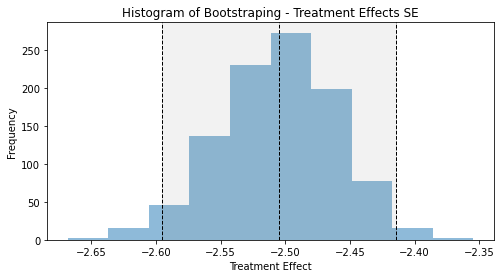

Mean treatment effect of bootstrap method is: -2.504763275639395
Standard error of treatment effects is: 0.045081024032602404


In [217]:
#Now plot the histogram
plt.figure(figsize=(8, 4)) 
plt.hist(coef, bins=10, alpha=0.5) #plot histogram of treatment effects

mean = np.mean(coef) #Find mean
std = np.std(coef) #Find standard deviation -- this is the standard error of treatment effects

lower_95 = mean - 2*std
upper_95 = mean + 2*std

plt.axvspan(lower_95, upper_95, alpha=0.1, color='grey') #Draw gray area which captures 95% CI
plt.axvline(mean, color='black', linestyle='dashed', linewidth=1) #Draw a line at mean treatment effect
plt.axvline(lower_95, color='black', linestyle='dashed', linewidth=1) #Draw lower bound
plt.axvline(upper_95, color='black', linestyle='dashed', linewidth=1) #Draw upper bound
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.title('Histogram of Bootstraping - Treatment Effects SE')

plt.show()
print("Mean treatment effect of bootstrap method is:",mean)
print("Standard error of treatment effects is:",std)

#### Question 4
Keeping 21 as the threshold for age, explore the data with an RDD by writing very simple code (no package needed, just average to one side of the threshold minus average to the other side) to determine if alcohol increases the chances of death by accident, suicide and/or others (the three given columns) and comment on the question “Should the legal age for drinking be reduced from 21?” based on the results. Plot graphs to show the discontinuity (if any) and to show results for the change in chances of death with all the three features (i.e., accident vs age, suicide vs age and others vs age). For this problem, choose the bandwidth to be 1 year (i.e., 21 +- 1). What might be the effect of choosing a smaller bandwidth?  What if we chose the maximum bandwidth?

Dataset : drinking.csv
Keeping 21 as the threshold for age, explore the data with an RDD

In [171]:
##Reading the data
drinking = pd.read_csv('drinking.csv') 
original_drinking = pd.read_csv('drinking.csv') 

Exploring the data and handling missing values

In [172]:
drinking.info() 
##There are two nulls in three columns
##Since we have only 50 observations, merely dropping the null columns would lose information
##Instead of removing rows, I would handle missing values by replacing them with central tendencies

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       50 non-null     float64
 1   others    48 non-null     float64
 2   accident  48 non-null     float64
 3   suicide   48 non-null     float64
dtypes: float64(4)
memory usage: 1.7 KB


/Users/sheetalrajgure/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='others'>

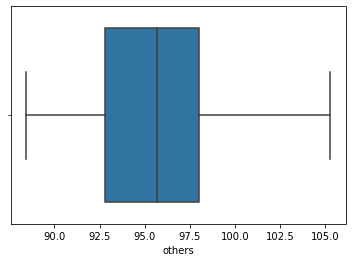

In [173]:
sns.boxplot(drinking.others)

/Users/sheetalrajgure/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='accident'>

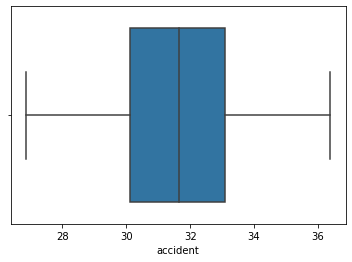

In [174]:

sns.boxplot(drinking.accident)

/Users/sheetalrajgure/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='suicide'>

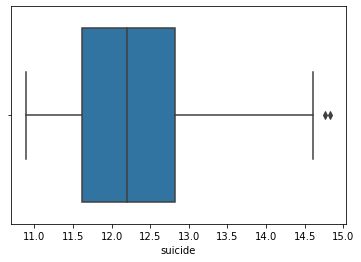

In [175]:
sns.boxplot(drinking.suicide)

In [176]:
#two of the three plots are left skewed, hence using mode to replace the missing values
drinking['others'] = drinking['others'].fillna(drinking['others'].mode()[0])
drinking['accident'] = drinking['accident'].fillna(drinking['accident'].mode()[0])
drinking['suicide'] = drinking['suicide'].fillna(drinking['suicide'].mode()[0])

In [177]:
drinking.info() ##Missing values handled

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       50 non-null     float64
 1   others    50 non-null     float64
 2   accident  50 non-null     float64
 3   suicide   50 non-null     float64
dtypes: float64(4)
memory usage: 1.7 KB


In [178]:
#Let's first convert the 'age' column to make it centred around 0. The cutoff 21 years would zero and other 
#ages would be described in terms of how away they are from the cutoff of 21 years
drinking["age"] -= 21
#print(drinking)

<AxesSubplot:xlabel='age', ylabel='suicide'>

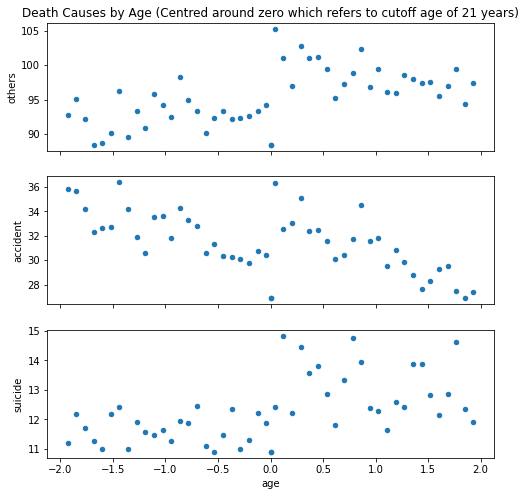

In [179]:
#Initial Plot
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
drinking.plot.scatter(x="age", y="others", ax=ax)
plt.title("Death Causes by Age (Centred around zero which refers to cutoff age of 21 years)")

ax = plt.subplot(3,1,2, sharex=ax)
drinking.plot.scatter(x="age", y="accident", ax=ax)

ax = plt.subplot(3,1,3, sharex=ax)
drinking.plot.scatter(x="age", y="suicide", ax=ax)

In [180]:
#Create a new column indicating 1 if age>=21 years, 0 otherwise
rdd_df = drinking.assign(threshold=(drinking["age"] >= 0).astype(int))
#print(drinking)

Part A:  write very simple code (no package needed, just average to one side of the threshold minus average to the other side) to determine if alcohol increases the chances of death by accident, suicide and/or others (the three given columns) and comment on the question “Should the legal age for drinking be reduced from 21?” based on the results. 

In [181]:
#A.Others
avg_others_l = drinking.loc[drinking['age'] < 0, 'others'].mean()
avg_others_u = drinking.loc[drinking['age'] >= 0, 'others'].mean()
print("The difference in average deaths due to 'others' for 21 years+ and below 21 years is:", avg_others_u-avg_others_l,"Average deaths with others reason are 5.5104 more on an average for alcohol consumers than non-alcohol consumers")


The difference in average deaths due to 'others' for 21 years+ and below 21 years is: 5.510442400000031 Average deaths with others reason are 5.5104 more on an average for alcohol consumers than non-alcohol consumers


In [182]:
#B.Accidents
avg_acc_l = drinking.loc[drinking['age'] < 0, 'accident'].mean()
avg_acc_u = drinking.loc[drinking['age'] >= 0, 'accident'].mean()
print("The difference in average deaths due to 'accident' for 21 years+ and below 21 years is:", avg_acc_u-avg_acc_l,"Average deaths due to accidents are 1.6102 less on an average for alcohol consumers than non-alcohol consumers")


The difference in average deaths due to 'accident' for 21 years+ and below 21 years is: -1.6102617199999862 Average deaths due to accidents are 1.6102 less on an average for alcohol consumers than non-alcohol consumers


In [183]:
#C.Suicide
avg_sui_l = drinking.loc[drinking['age'] < 0, 'suicide'].mean()
avg_sui_u = drinking.loc[drinking['age'] >= 0, 'suicide'].mean()
print("The difference in average deaths due to 'suicide' for 21 years+ and below 21 years is:", avg_sui_u-avg_sui_l,"Average deaths due to suicide are 1.3789 more on an average for alcohol consumers than non-alcohol consumers")

The difference in average deaths due to 'suicide' for 21 years+ and below 21 years is: 1.3789842400000047 Average deaths due to suicide are 1.3789 more on an average for alcohol consumers than non-alcohol consumers


INTERPRETATION: From above results, it is not clear whether the legal age be reduced or not. Because deaths due to accidents are more for non-drinking audience. But deaths due to suicide and others are higher for drinking audience. This means that alcoholism does not cause more deaths due to accidents and we would say reduce the age limit for drinking. But for suicide and other reasons, alcoholism causes more deaths, hence do not reduce.

Here we are missing an important point of confounding effects. Let is handle those in part B

Part B: Plot graphs to show the discontinuity (if any) and to show results for the change in chances of death with all the three features (i.e., accident vs age, suicide vs age and others vs age). For this problem, choose the bandwidth to be 1 year (i.e., 21 +- 1)

In [184]:
#For bandwidth 1 year
#A.Others
avg_others_l_band = drinking.loc[(drinking['age'] < 0) & (drinking['age'] >= -1) , 'others'].mean() ##includes -1
avg_others_u_band = drinking.loc[(drinking['age'] >= 0) & (drinking['age'] <= 1), 'others'].mean() ##includes 1
print("The difference in average deaths due to 'others' for 21 years+ and below 21 years with 1 year bandwidth:", avg_others_u_band - avg_others_l_band ,"Average deaths with others reason are 6.0385 more on an average for alcohol consumers than non-alcohol consumers.")

#B. Accident
avg_acc_l_band = drinking.loc[(drinking['age'] < 0) & (drinking['age'] >= -1) , 'accident'].mean() ##includes -1
avg_acc_u_band = drinking.loc[(drinking['age'] >= 0) & (drinking['age'] <= 1), 'accident'].mean() ##includes 1
print("The difference in average deaths due to 'accident' for 21 years+ and below 21 years with 1 year bandwidth:", avg_acc_u_band - avg_acc_l_band ,"Average deaths due to accidents are 1.236 more on an average for alcohol consumers than non-alcohol consumers.")

#C. Suicide
avg_sui_l_band = drinking.loc[(drinking['age'] < 0) & (drinking['age'] >= -1) , 'suicide'].mean() ##includes -1
avg_sui_u_band = drinking.loc[(drinking['age'] >= 0) & (drinking['age'] <= 1), 'suicide'].mean() ##includes 1
print("The difference in average deaths due to 'suicide' for 21 years+ and below 21 years with 1 year bandwidth:", avg_sui_u_band - avg_sui_l_band ,"Average deaths due to suicides are 1.587 more on an average for alcohol consumers than non-alcohol consumers.")

The difference in average deaths due to 'others' for 21 years+ and below 21 years with 1 year bandwidth: 6.03845546153849 Average deaths with others reason are 6.0385 more on an average for alcohol consumers than non-alcohol consumers.
The difference in average deaths due to 'accident' for 21 years+ and below 21 years with 1 year bandwidth: 1.2355253846153857 Average deaths due to accidents are 1.236 more on an average for alcohol consumers than non-alcohol consumers.
The difference in average deaths due to 'suicide' for 21 years+ and below 21 years with 1 year bandwidth: 1.58684153846154 Average deaths due to suicides are 1.587 more on an average for alcohol consumers than non-alcohol consumers.


This difference is closer to reality as we have now randomized the observations. Earlier when we were considering entire observations below cut-off and above cut-off, there was a risk of confounding effects. However, choosing observations very near to the cut-off, we ensure randomization which in turn gives us the actual treatment effect.

Here, we see that average deaths for alcohol consumers due to any reason is higher than those who do not consume alcohol. This is the ATE, the average effect of alcohol consumption.

Thus, alcoholism causes more deaths due to any of the listed reasons, hence, the age limit should not be reduced.

In [ ]:
#Lets see what happens if we change bandwidth

In [185]:
avg_others_l_band = drinking.loc[(drinking['age'] < 0) & (drinking['age'] >= -0.5) , 'others'].mean() ##includes -1
avg_others_u_band = drinking.loc[(drinking['age'] >= 0) & (drinking['age'] <= 0.5), 'others'].mean() ##includes 1
print("The difference in average deaths due to 'others' for 21 years+ and below 21 years with 1 year bandwidth:", avg_others_u_band - avg_others_l_band )

#B. Accident
avg_acc_l_band = drinking.loc[(drinking['age'] < 0) & (drinking['age'] >= -0.5) , 'accident'].mean() ##includes -1
avg_acc_u_band = drinking.loc[(drinking['age'] >= 0) & (drinking['age'] <= 0.5), 'accident'].mean() ##includes 1
print("The difference in average deaths due to 'accident' for 21 years+ and below 21 years with 1 year bandwidth:", avg_acc_u_band - avg_acc_l_band )

#C. Suicide
avg_sui_l_band = drinking.loc[(drinking['age'] < 0) & (drinking['age'] >= -0.5) , 'suicide'].mean() ##includes -1
avg_sui_u_band = drinking.loc[(drinking['age'] >= 0) & (drinking['age'] <= 0.5), 'suicide'].mean() ##includes 1
print("The difference in average deaths due to 'suicide' for 21 years+ and below 21 years with 1 year bandwidth:", avg_sui_u_band - avg_sui_l_band )

The difference in average deaths due to 'others' for 21 years+ and below 21 years with 1 year bandwidth: 7.157360999999966
The difference in average deaths due to 'accident' for 21 years+ and below 21 years with 1 year bandwidth: 2.900628857142859
The difference in average deaths due to 'suicide' for 21 years+ and below 21 years with 1 year bandwidth: 1.5843159999999994


In [186]:
avg_others_l_band = drinking.loc[(drinking['age'] < 0) & (drinking['age'] >= -2) , 'others'].mean() ##includes -1
avg_others_u_band = drinking.loc[(drinking['age'] >= 0) & (drinking['age'] <= 2), 'others'].mean() ##includes 1
print("The difference in average deaths due to 'others' for 21 years+ and below 21 years with 1 year bandwidth:", avg_others_u_band - avg_others_l_band )

#B. Accident
avg_acc_l_band = drinking.loc[(drinking['age'] < 0) & (drinking['age'] >= -2) , 'accident'].mean() ##includes -1
avg_acc_u_band = drinking.loc[(drinking['age'] >= 0) & (drinking['age'] <= 2), 'accident'].mean() ##includes 1
print("The difference in average deaths due to 'accident' for 21 years+ and below 21 years with 1 year bandwidth:", avg_acc_u_band - avg_acc_l_band )

#C. Suicide
avg_sui_l_band = drinking.loc[(drinking['age'] < 0) & (drinking['age'] >= -2) , 'suicide'].mean() ##includes -1
avg_sui_u_band = drinking.loc[(drinking['age'] >= 0) & (drinking['age'] <= 2), 'suicide'].mean() ##includes 1
print("The difference in average deaths due to 'suicide' for 21 years+ and below 21 years with 1 year bandwidth:", avg_sui_u_band - avg_sui_l_band )

The difference in average deaths due to 'others' for 21 years+ and below 21 years with 1 year bandwidth: 5.510442400000031
The difference in average deaths due to 'accident' for 21 years+ and below 21 years with 1 year bandwidth: -1.6102617199999862
The difference in average deaths due to 'suicide' for 21 years+ and below 21 years with 1 year bandwidth: 1.3789842400000047


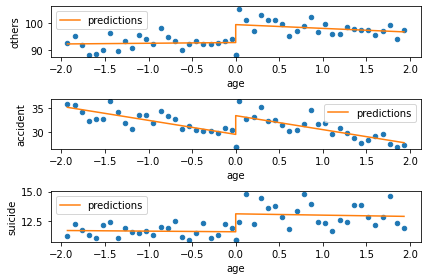

In [187]:
for p, cause in enumerate(["others","accident", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="age", y=cause, ax=ax)
    m = smf.ols(f"{cause}~age*threshold", rdd_df).fit()
    drinking.assign(predictions=m.fittedvalues).plot(x="age", y="predictions", ax=ax, color="C1")

plt.tight_layout()

What might be the effect of choosing a smaller bandwidth?  What if we chose the maximum bandwidth?
Answer: By choosing a smaller bandwidth, we would have lesser observations to draw conclusion from and the outcomes would be less precise. On the other hand, maximum bandwidth is like considering the entire dataset. Observations away from the cut-off threshold are not truly randomized, we can not consider them as randomized. There are other confounding factors, however observations closer to cutoff can be assumed to be similar and that they are in treatment or control is purely by chance. Hence this is random sample, and we get the ATE from these observations. Choosing maximum bandwidth would give us incorrect ATE. 

For demo, I have tried keeping the bandwidth as 0.5 and 2. As we can see, when the bandwidth is broaden, we get negative treatment effect on accident (accident deaths less in alcoholics) which is flipped when we use 1 year as bandwidth. For 0.5 years, we do not have many observations to concretize our results, hence a balance is required.

#### Question 5: knn
Using Iris dataset, How does the performance of k-nearest neighbors change as k takes on the following values: 1, 3, 5, 7? Which of these is the optimal value of k? Which distance/similarity metric did you choose to use and why?

In [188]:

iris = pd.read_csv('iris.csv')
iris['variety'].value_counts() ##There are 3 categories

Setosa        50
Versicolor    50
Virginica     50
Name: variety, dtype: int64

In [189]:
iris.info() 
##Looks like there are no missing values
iris.describe().T
##Looks like there are no outliers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


,count,mean,std,min,25%,50%,75%,max
sepal.length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal.width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal.length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal.width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


Here, we have 150 observations, to check the performance I would split the dataset into 80% train and 20% test. 
Then, use Eucledian distances to classify each observation in training set into k classes. Then, check performance on testing dataset 

In [190]:
##Define X and Y variables - Y is class in which we want to classify out observations
X = iris.iloc[:, :-1].values
y = iris.iloc[:, 4].values

In [211]:
#Split the datasets into train and test subsets
import random
random.seed(100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 

In [212]:
##First, let us scale all independent variables to avoid effects of varying scales on our model
##I would be using Standard Scalar module 
scaler = StandardScaler()

#Scaling Train and test datasets
# Fit only on X_train
scaler.fit(X_train)

# Scale both X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [213]:
#The scaler maintains only the data points, and not the column names, when applied on a dataframe
col_names=['sepal.length', 'sepal.width','petal.length','petal.width']
scaled_df = pd.DataFrame(X_train, columns=col_names)
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal.length,120.0,-2.256528e-15,1.004193,-1.917308,-0.933022,-0.071771,0.666444,2.511982
sepal.width,120.0,-3.407922e-15,1.004193,-2.429278,-0.566573,-0.100897,0.597618,2.693161
petal.length,120.0,-5.097774e-16,1.004193,-1.616869,-1.267695,0.303587,0.769153,1.816674
petal.width,120.0,-5.255056e-16,1.004193,-1.505606,-1.231444,0.139366,0.824771,1.784338


In [214]:
random.seed(100)
##Find the best distance measure using trying out different measures for same k:
for p_measure in np.arange(1, 6):
    knn = KNeighborsClassifier(n_neighbors=3, p = p_measure) 
    knn.fit(X_train, y_train)
    print("For k = 3 and p = %d accuracy is :"%p_measure,knn.score(X_test,y_test))   
#Here we checked Manhattan distance, euclidean distance and minkowski distance with 3,4, and 5 powers

For k = 3 and p = 1 accuracy is : 0.9
For k = 3 and p = 2 accuracy is : 0.9333333333333333
For k = 3 and p = 3 accuracy is : 0.9333333333333333
For k = 3 and p = 4 accuracy is : 0.9333333333333333
For k = 3 and p = 5 accuracy is : 0.9333333333333333


In [215]:
#Calculate the accuracy of the model for different values of k with p =2 i.e. using Euclidean distance
#define an array of k's
for i in [1,3,5,7]:
    knn2 = KNeighborsClassifier(n_neighbors=i) ##default p is 2 i.e. its using Euclidean distance measure
    knn2.fit(X_train, y_train)
    print("For k = %d accuracy is"%i,knn2.score(X_test,y_test))

For k = 1 accuracy is 0.9333333333333333
For k = 3 accuracy is 0.9333333333333333
For k = 5 accuracy is 0.9333333333333333
For k = 7 accuracy is 0.9666666666666667


Which of these is the optimal value of k? Which distance/similarity metric did you choose to use and why?
Answer: 
From above results, we get optimal results when k = 7. I used the Euclidean metrics because it is most widely used in knn. I also checked the performance of different distance measures manhattan, euclidean, minkowski - for Euclidean I got 97% accuracy at k = 7. which is higher than manhatten and equal to higher power minkowski
